# Milestone 3
This notebook should be connected with milestone 2 at one point, but easier to work with two different notebooks.

In [12]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns; sns.set()
from matplotlib.font_manager import FontProperties

### Question 1 - How has the crops and livestock production changed since the 1960s?
To get a general picture of how production has changed we start by looking at everything at a world-level.

This question will serve as an intro to the whole project and look at the big trends in the world, with focus on products more than areas. We will mainly study total development of production (without normalizing for population), as this is how the production actually has developed and how the scale has changed during the 50 years.
We will follow these steps:

- Get an overview of development by analyzing at world-level.
- Look if any special products have increased/decreased in popularity.
- Find statistical indicators showing the differences now and in 1960.
- Look for certain countries and areas that stand out.

In [13]:
# Load data
data_path = 'data/pickles/'
meat_cont = pd.read_pickle(data_path + 'meat_continents.pkl')
crops_cont = pd.read_pickle(data_path + 'crops_continents.pkl')
pop_cont = pd.read_pickle(data_path + 'pop_continents.pkl')

In [14]:
from imp import reload
import scripts.visualization
reload(scripts.visualization)
from scripts.visualization import *

In [15]:
meat_total = meat_cont[meat_cont['Item'] == 'Meat, Total']

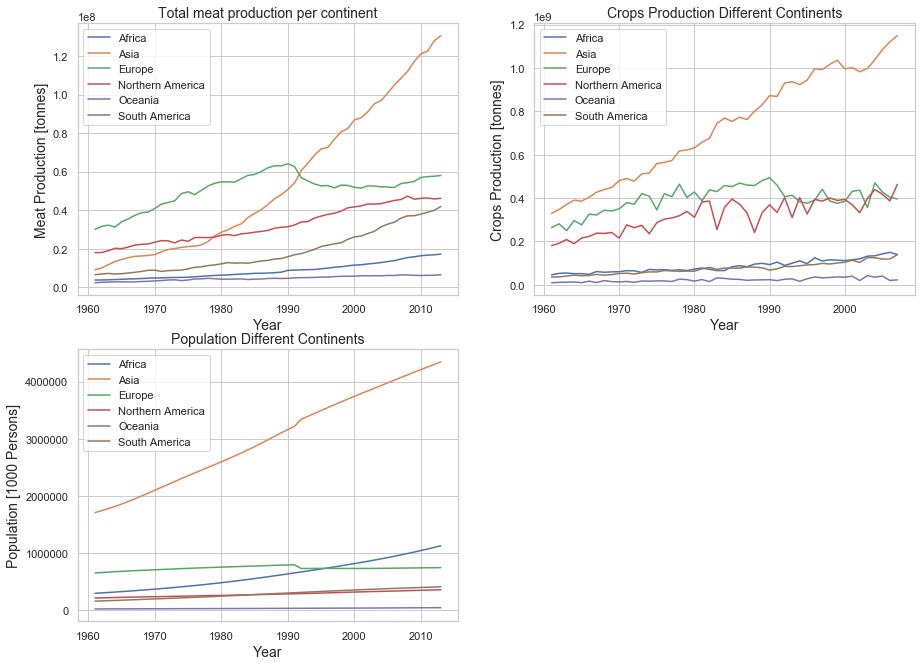

In [16]:
fig = plt.figure(figsize = (15, 11))

ax1 = plt.subplot(2,2,1)
plot_compare_areas(meat_cont[(meat_cont['Item'] == 'Meat indigenous, total')], 
                    y = 'Value', y_label = 'Meat Production [tonnes]',
                    title='Total meat production per continent',
                    subplot = True, ax = ax1)

# I think this plot is wrong, as it is plotting the total cereal production, 
# not total crop production yearly like the title states.
ax2 = plt.subplot(2,2,2)
plot_compare_areas(crops_cont[(crops_cont['Item'] == 'cereals_total')], 
                    y = 'Value', y_label = 'Crops Production [tonnes]',
                    title='Crops Production Different Continents',
                    subplot = True, ax = ax2)

ax3 = plt.subplot(2,2,3)
plot_compare_areas(pop_cont, 
                    y = 'Value', y_label = 'Population [1000 Persons]',
                    title='Population Different Continents',
                    subplot = True, ax = ax3)

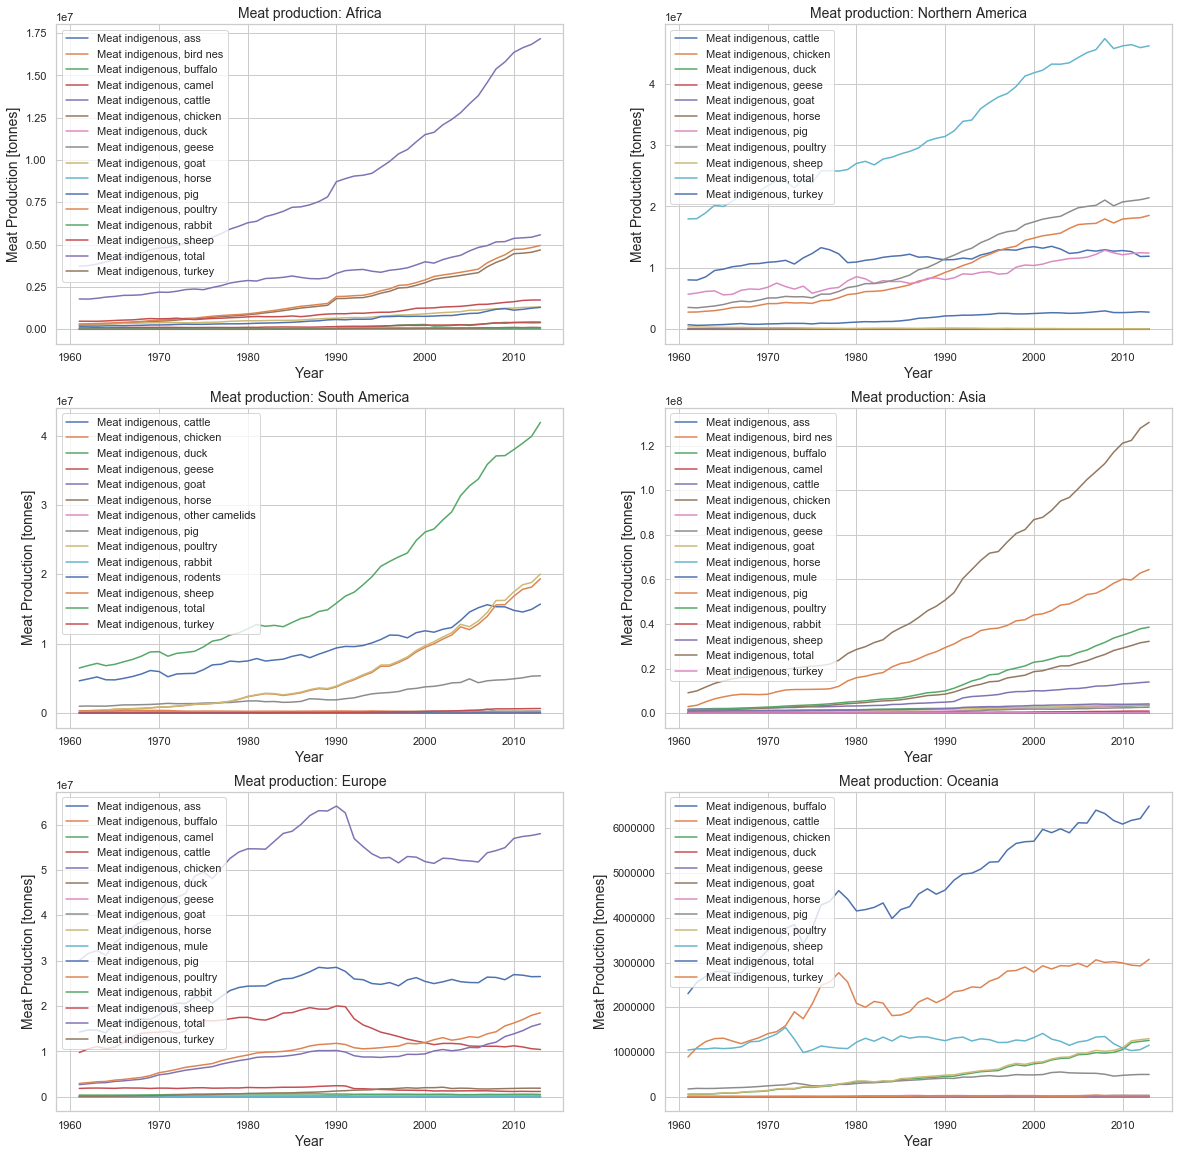

In [17]:
# WIP, Area wise plots of meat production. Still need to do the same for crops and 
# improve legend so that it does not overlap with curves.
meat_indigenous = meat_cont[meat_cont['Item'].str.contains('indigenous')]

fig = plt.figure(figsize = (20, 20))
i = 0

for area in meat_indigenous.Area.unique():
    i+=1
    plot_compare_areas(meat_indigenous[meat_indigenous['Area'] == area], grouping = 'Item',
                  y = 'Value', y_label = 'Meat Production [tonnes]', title='Meat production: '+area,
                    subplot = True, ax = plt.subplot(3, 2, i))

Text(0.5, 1.0, 'Mean yearly (%) increase of different crops')

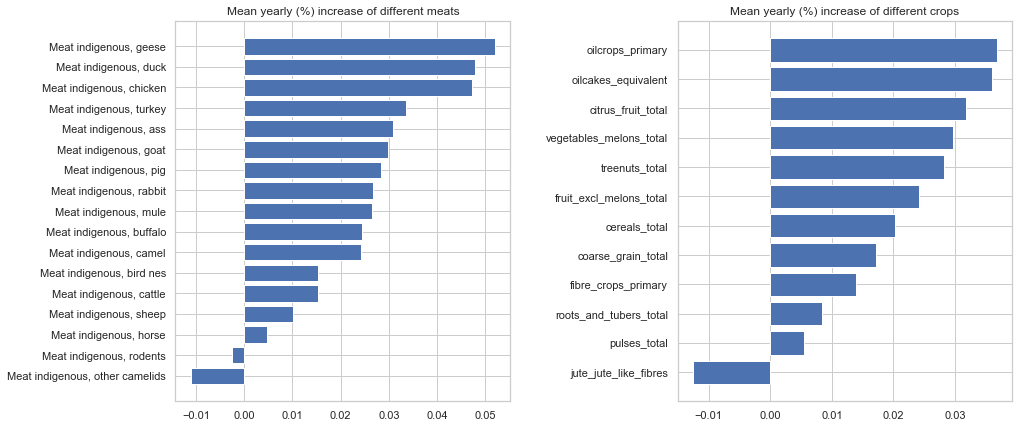

In [18]:
#Comparison of the yearly increases of different meat and crop production. 

fig, ax = plt.subplots(ncols = 2)
fig.set_size_inches(15,7)
fig.subplots_adjust(wspace = 0.5)

#Create dataframes with mean yearly change in production of different products
mean_mproduct_growth = {}
for meat_product in meat_indigenous.Item.unique():
    if (meat_product != 'Meat indigenous, total') & (meat_product != 'Meat indigenous, poultry'):
        mean_mproduct_growth.update({meat_product: (meat_indigenous[meat_indigenous['Item'] == meat_product].groupby('Year').sum().diff()/\
              meat_indigenous[meat_indigenous['Item'] == meat_product].groupby('Year').sum()).Value.mean()})

mean_mproduct_growth = pd.DataFrame(mean_mproduct_growth.values(), mean_mproduct_growth.keys(), columns = ['Mean growth'])
mean_mproduct_growth.sort_values(by='Mean growth', inplace =True)


mean_cproduct_growth = {}
for crop in crops_cont.Item.unique():
    mean_cproduct_growth.update({crop : (crops_cont[crops_cont['Item'] == crop].groupby(['Year']).sum().diff()/\
                                 crops_cont[crops_cont['Item'] == crop].groupby(['Year']).sum()).Value.mean()})

mean_cproduct_growth = pd.DataFrame(mean_cproduct_growth.values(), mean_cproduct_growth.keys(), columns = ['Mean growth'])
mean_cproduct_growth.sort_values(by='Mean growth', inplace =True)


ax[0].barh(mean_mproduct_growth.index, mean_mproduct_growth['Mean growth'])
ax[0].set_title("Mean yearly (%) increase of different meats")

ax[1].barh(mean_cproduct_growth.index, mean_cproduct_growth['Mean growth'])
ax[1].set_title("Mean yearly (%) increase of different crops")

We can see that that most products have experienced a positive average growth yearly. Only production of other camelids and jute like fibres has decreased.

### Question 2 - Is there a connection between the development of livestock primary production and crop production?

The purpose of this question is to see if there are any trends in our data, and to answer this we will study both total and normalized data. We will also have to look at

- Are we producing more food per person?
- Has the porportions of meat vs. crops changed in our diet?
- Can we see differences between each continent?

In [26]:
# Calculating year on year growth of meat and crop production
mean_meat_prodgrow = (meat_cont[meat_cont['Item'] == 'Meat, Total'].groupby('Year').sum().diff()/\
    meat_cont[meat_cont['Item'] == 'Meat, Total'].groupby('Year').sum()).Value.mean()*100

mean_crop_prodgrow = (crops_cont[crops_cont['Item'] == 'cereals_total'].groupby('Year').sum().diff()/\
    crops_cont[crops_cont['Item'] == 'cereals_total'].groupby('Year').sum()).Value.mean()*100

mean_pop_growth = (pop_cont.groupby('Year').sum().diff()/pop_cont.groupby('Year').sum()).Value.mean()*100

print("Meat production has grown on average by %2.2f%% yearly, while crops production has grown by %2.2f%%." \
      % (mean_meat_prodgrow, mean_crop_prodgrow))
print("Meanwhile the population has grown on average by %2.2f %% yearly." \
      % (mean_pop_growth))

Meat production has grown on average by 2.79% yearly, while crops production has grown by 2.03%.
Meanwhile the population has grown on average by 1.61 % yearly. 
In other words, food production has experienced more rapid growth than population.


From the results above, it is  food production has experienced more rapid growth than population.

### Question 3 - How are the differences in production quantities between the different continents?

The purpose of this question is to study the difference in production at a continent-level. For example, it can be interesting to see the difference between developed continents, like Europe and North-America, and continents like Africa and Asia.

- Study food production in general, and with a crops vs. meat analysis.
- What can be said about the normalized production?
- Can we say if any continents are producing more than it needs?
- Try to find data on how much food a person needs per year.
    - This is pretty hard because of energy/tonne

### Question 4 - How has the development in agriculture affected emission of greenhouse gasses?

This question is about the consequences of what we have studied in the previous questions.

- Can we find evidence that higher meat consumption leads to higher emissions?
- Is it better for the environment to eat crops rather than livestock?
- Are there any particular meat or crop that affect the CO2 emissions more/less than the average?